In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from seq2seq import *
import pickle
from sklearn import metrics

from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seeds(seed):
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Convert a string that simulates a list to a real list
def convert_string_list(element):
    # Delete [] of the string
    element = element[0:len(element)]
    # Create a list that contains each code as e.g. 'A'
    ATC_list = list(element.split('; '))
    for index, code in enumerate(ATC_list):
        # Delete '' of the code
        ATC_list[index] = code[0:len(code)]
    return ATC_list

In [4]:
def multiplicate_rows(df):
    # Duplicate each compound the number of ATC codes associated to it, copying its SMILES in new rows
    new_rows = []
    
    for _, row in df.iterrows():
        atc_codes = row['ATC Codes']
        atc_codes_list = convert_string_list(atc_codes)
        
        if len(atc_codes_list) > 1:
            for code in atc_codes_list:
                if len(code) == 5:
                    new_row = row.copy()
                    new_row['ATC Codes'] = code
                    new_rows.append(new_row)
        else:
            if len(atc_codes_list[0]) == 5:
                new_rows.append(row)
    
    new_set = pd.DataFrame(new_rows)
    new_set = new_set.reset_index(drop=True)

    return new_set

def extract_descriptors(df):
    """
    Extract molecular descriptors from your dataset.
    You'll need to implement this based on your descriptor source.
    
    Returns FloatTensor of shape (n_molecules, descriptor_dimension)
    """
    descriptors = df.iloc[:, 2:-5].values
    # Convert to numpy for easier handling
    if isinstance(descriptors, torch.Tensor):
        desc_array = descriptors.numpy()
    else:
        desc_array = np.array(descriptors)
    
    # Replace infinite values with NaN first
    desc_array[np.isinf(desc_array)] = np.nan
    
    # Calculate median for each feature (column-wise)
    medians = np.nanmedian(desc_array, axis=0)
    
    # Replace NaN values with corresponding median
    for i in range(desc_array.shape[1]):
        mask = np.isnan(desc_array[:, i])
        desc_array[mask, i] = medians[i]
    return torch.tensor(desc_array, dtype=torch.float32)
    
# Create vocabularies
# Tokenize the data
def source(df):
    source = []
    for compound in df['Neutralized SMILES']:
        # A list containing each SMILES character separated
        source.append(list(compound))
    return source
def target(df):
    target = []
    for codes in df['ATC Codes']:  
        code = convert_string_list(codes) 
        # A list of lists, each one containing each ATC code character separated 
        for c in code:
            list_c = list(c)
            target.append(list_c)
    return target

In [5]:
set_seeds(78)

train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")
test_set = pd.read_csv("test_set.csv")

train_set_meta = pd.concat([train_set, val_set])
train_set_meta = shuffle(train_set_meta, random_state = 42)
train_set_meta = train_set_meta.reset_index(drop=True)

new_train_set = multiplicate_rows(train_set_meta)
new_test_set = multiplicate_rows(test_set)

train_descriptors = extract_descriptors(new_train_set)
train_descriptors2 = extract_descriptors(train_set_meta)
test_descriptors = extract_descriptors(new_test_set)
test_descriptors2 = extract_descriptors(test_set)

scaler = StandardScaler()
train_descriptors = torch.tensor(scaler.fit_transform(train_descriptors.numpy()), dtype=torch.float32)
train_descriptors2 = torch.tensor(scaler.transform(train_descriptors2.numpy()), dtype=torch.float32)
test_descriptors = torch.tensor(scaler.transform(test_descriptors.numpy()), dtype=torch.float32)
test_descriptors2 = torch.tensor(scaler.transform(test_descriptors2.numpy()), dtype=torch.float32)

source_train = source(new_train_set)
source_train2 = source(train_set_meta)
source_test = source(new_test_set)
# Test set without duplicated compounds
source_test2 = source(test_set)

target_train = target(new_train_set)
target_test = target(new_test_set)

# An Index object represents a mapping from the vocabulary to integers (indices) to feed into the models
source_index = torch.load("source_index.pt", weights_only=False)
target_index = torch.load("target_index.pt", weights_only=False)

# Create tensors
X_train = source_index.text2tensor(source_train)
X_train2 = source_index.text2tensor(source_train2)
y_train = target_index.text2tensor(target_train)    
X_test = source_index.text2tensor(source_test)
X_test2 = source_index.text2tensor(source_test2)
y_test = target_index.text2tensor(target_test)

if torch.cuda.is_available():
    X_train = X_train.to("cuda")
    X_train2 = X_train2.to("cuda")
    y_train = y_train.to("cuda")
    train_descriptors = train_descriptors.to("cuda") 
    train_descriptors2 = train_descriptors2.to("cuda") 
    test_descriptors = test_descriptors.to("cuda")
    test_descriptors2 = test_descriptors2.to("cuda")
    X_test= X_test.to("cuda")
    y_test = y_test.to("cuda")
    X_test2 = X_test2.to("cuda")

model = pickle.load(open("model_multimodalTransformer.pkl", 'rb'))
model.to("cuda")
loss, error_rate = model.evaluate(X_test, test_descriptors, y_test, batch_size = 32) 

In [6]:
torch.cuda.empty_cache()

In [7]:
b_width = 10
predictions, log_probabilities = search_algorithms.multimodal_beam_search(
    model, 
    X_train2,
    train_descriptors2,
    predictions = 6, # max length of the predicted sequence
    beam_width = b_width,
    batch_size = 32, 
    progress_bar = 0
)
output_beam = [target_index.tensor2text(p) for p in predictions]

In [8]:
output_beam

[['<START>M03AC<END>',
  '<START>M03AA<END>',
  '<START>M01AC<END>',
  '<START>M03AX<END>',
  '<START>M03AM<END>',
  '<START>M03BA<END>',
  '<START>M03AB<END>',
  '<START>M03CA<END>',
  '<START>M03AE<END>',
  '<START>A03AC<END>'],
 ['<START>N05CA<END>',
  '<START>N05CB<END>',
  '<START>N05BA<END>',
  '<START>N05CM<END>',
  '<START>N05CX<END>',
  '<START>N05AA<END>',
  '<START>N05CF<END>',
  '<START>N05AF<END>',
  '<START>N05AX<END>',
  '<START>N05CN<END>'],
 ['<START>S01BA<END>',
  '<START>S01CA<END>',
  '<START>D07AB<END>',
  '<START>H02AB<END>',
  '<START>D07XB<END>',
  '<START>D07XA<END>',
  '<START>S02BA<END>',
  '<START>D07AX<END>',
  '<START>D07BA<END>',
  '<START>D07XC<END>'],
 ['<START>J04AM<END>',
  '<START>B01AC<END>',
  '<START>A11HA<END>',
  '<START>J01XX<END>',
  '<START>A01AB<END>',
  '<START>J04AH<END>',
  '<START>B03AA<END>',
  '<START>J01MB<END>',
  '<START>R03AX<END>',
  '<START>J04AX<END>'],
 ['<START>D10AX<END>',
  '<START>D10AD<END>',
  '<START>R03DX<END>',
  '<STA

In [9]:
def metrics_calc(output_beam, df, k):
    f1s = []
    for i, preds in enumerate(output_beam):
        ground_truth = convert_string_list(df['ATC Codes'][i])
        binary_predictions = []
        binary_ground_truth = []
        clean_preds = []
        for pred in preds[0:k]:
            p = pred[7:-5]
            clean_preds.append(p)
        set_pred_gt = list(set(clean_preds + ground_truth))
        for code in set_pred_gt:
            if code in clean_preds:
                binary_predictions.append(1)
            else:
                binary_predictions.append(0)
            if code in ground_truth:
                binary_ground_truth.append(1)
            else:
                binary_ground_truth.append(0)    
        f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    return f1s

In [10]:
f1s1 = metrics_calc(output_beam, train_set_meta, 1)
f1s2 = metrics_calc(output_beam, train_set_meta, 2)
f1s3 = metrics_calc(output_beam, train_set_meta, 3)
f1s4 = metrics_calc(output_beam, train_set_meta, 4)
f1s5 = metrics_calc(output_beam, train_set_meta, 5)
f1s6 = metrics_calc(output_beam, train_set_meta, 6)
f1s7 = metrics_calc(output_beam, train_set_meta, 7)
f1s8 = metrics_calc(output_beam, train_set_meta, 8)
f1s9 = metrics_calc(output_beam, train_set_meta, 9)
f1s10 = metrics_calc(output_beam, train_set_meta, 10)

In [11]:
f1 = pd.DataFrame(columns=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
f1["1"] = f1s1
f1["2"] = f1s2
f1["3"] = f1s3
f1["4"] = f1s4
f1["5"] = f1s5
f1["6"] = f1s6
f1["7"] = f1s7
f1["8"] = f1s8
f1["9"] = f1s9
f1["10"] = f1s10

In [12]:
print(sum(f1s3)/len(f1s3))

0.4181933926790967


In [13]:
f1

,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
1,1.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2,0.000000,0.000000,0.4,0.333333,0.571429,0.500000,0.444444,0.400000,0.363636,0.333333
3,0.666667,0.500000,0.8,0.666667,0.571429,0.500000,0.444444,0.400000,0.363636,0.333333
4,0.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
...,...,...,...,...,...,...,...,...,...,...
2556,1.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2557,0.500000,0.800000,1.0,0.857143,0.750000,0.666667,0.600000,0.545455,0.500000,0.461538
2558,1.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2559,1.000000,0.666667,0.5,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818


In [14]:
col_max_por_fila = f1.idxmax(axis=1)
filas_todo_cero = (f1 == 0.0).all(axis=1)
col_max_por_fila[filas_todo_cero] = '0'

In [15]:
col_max_por_fila.tolist()

['1',
 '1',
 '5',
 '3',
 '2',
 '1',
 '1',
 '3',
 '1',
 '2',
 '4',
 '2',
 '2',
 '2',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '3',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '2',
 '2',
 '2',
 '5',
 '1',
 '2',
 '1',
 '1',
 '3',
 '2',
 '4',
 '1',
 '3',
 '1',
 '4',
 '2',
 '2',
 '2',
 '0',
 '2',
 '1',
 '2',
 '1',
 '1',
 '9',
 '1',
 '0',
 '4',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '0',
 '0',
 '1',
 '4',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '3',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '3',
 '0',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '4',
 '2',
 '1',
 '1',
 '1',
 '2',
 '10',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '4',
 '1',
 '1',
 '1',
 '4',
 '2',
 '1',
 '4',
 '1',
 '2',
 '1',
 '4',
 '1',
 '5',
 '2',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '2',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '6',
 '1',
 '1',
 '2',
 '0',
 '1',
 '0',
 '1',
 '2',
 '2',
 '0',
 '1',
 '3',
 '1',
 '3',
 '2',
 '1',
 '1',
 '1',
 '1

In [16]:
log_probabilities[5]

tensor([-1.1405, -1.6725, -3.2105, -3.4714, -3.7742, -3.8008, -3.8702, -3.9883,
        -4.0305, -4.0488], device='cuda:0')

In [17]:
X = log_probabilities.cpu().numpy()
y = np.array(col_max_por_fila, dtype=np.float32)

In [18]:
X.shape

(2561, 10)

In [19]:
from keras import backend as K
import gc
K.clear_session()
gc.collect()

0

In [20]:
nn = Sequential([
    (Dense(1, input_dim = X.shape[1], activation = 'linear'))
])
# nn = Sequential([ 
#     Dense(64, input_dim=X.shape[1], activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1, activation='linear')
# ])
# Compile the model
nn.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['mae']
)

# Define early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True, verbose = 1)

# Train the model
history = nn.fit(
    X, 
    y, 
    epochs = 5000, 
    batch_size = 64,
    validation_split = 0.15,
    callbacks = [callback], 
    verbose = 0
)

C:\Users\trini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 412: early stopping
Restoring model weights from the end of the best epoch: 407.


In [21]:
pickle.dump(nn, open('meta-model_multimodaltransformer.pkl','wb'))

In [22]:
b_width = 10
predictions_test, log_probabilities_test = search_algorithms.multimodal_beam_search(
    model, 
    X_test2, # Make predictions with test set
    test_descriptors2,
    predictions = 6, # max length of the predicted sequence
    beam_width = b_width,
    batch_size = 32, 
    progress_bar = 0
)
output_beam_test = [target_index.tensor2text(p) for p in predictions_test]

In [23]:
y_pred = nn.predict(log_probabilities_test.cpu().numpy())

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


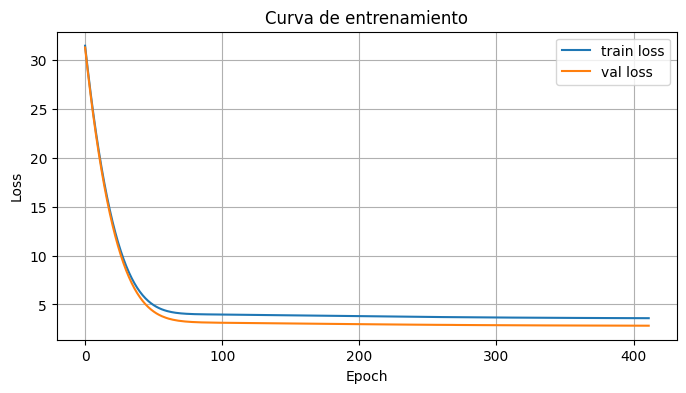

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
y_pred

array([[2.0026772 ],
       [1.4652152 ],
       [1.6889061 ],
       [1.7461519 ],
       [2.3293693 ],
       [2.2591612 ],
       [2.108577  ],
       [2.12054   ],
       [1.6453595 ],
       [2.4077756 ],
       [2.8890493 ],
       [2.1367033 ],
       [1.5572736 ],
       [2.7181535 ],
       [1.3521324 ],
       [2.2225108 ],
       [1.4127071 ],
       [2.1123614 ],
       [1.999774  ],
       [1.8597656 ],
       [1.716002  ],
       [1.977371  ],
       [2.2476423 ],
       [1.6360091 ],
       [1.5692811 ],
       [1.9417307 ],
       [1.8971932 ],
       [1.5811484 ],
       [1.1817874 ],
       [2.2605894 ],
       [2.015684  ],
       [1.8979443 ],
       [1.9632524 ],
       [2.210743  ],
       [2.4540827 ],
       [2.2438133 ],
       [2.0008717 ],
       [1.7177837 ],
       [1.3697962 ],
       [2.4626327 ],
       [1.929316  ],
       [2.2047355 ],
       [2.3541722 ],
       [2.0322127 ],
       [2.063777  ],
       [1.3596635 ],
       [1.438216  ],
       [2.121

In [26]:
y_pred_int = y_pred.round().astype(int)

In [27]:
y_pred_int

array([[2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [2],
       [3],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
    

In [28]:
optimized_output = []
for i, out in enumerate(output_beam_test):
    optimized_output.append(out[0:y_pred_int[i][0]])

In [29]:
optimized_output

[['<START>L01CA<END>', '<START>L01CX<END>'],
 ['<START>J01DH<END>'],
 ['<START>P01BC<END>', '<START>P01BB<END>'],
 ['<START>L01AA<END>', '<START>L01AD<END>'],
 ['<START>J01XX<END>', '<START>D07AX<END>'],
 ['<START>J05AX<END>', '<START>D11AX<END>'],
 ['<START>J05AR<END>', '<START>J05AF<END>'],
 ['<START>J05AX<END>', '<START>L04AA<END>'],
 ['<START>J05AX<END>', '<START>L01XX<END>'],
 ['<START>J01XD<END>', '<START>J01DC<END>'],
 ['<START>G01AE<END>', '<START>C03AA<END>', '<START>C03BA<END>'],
 ['<START>A11CC<END>', '<START>A14AX<END>'],
 ['<START>J01XX<END>', '<START>J01RA<END>'],
 ['<START>D11AX<END>', '<START>L01XX<END>', '<START>D01AC<END>'],
 ['<START>A04AA<END>'],
 ['<START>N03AX<END>', '<START>N07XX<END>'],
 ['<START>J05AB<END>'],
 ['<START>L01XX<END>', '<START>L01EX<END>'],
 ['<START>S01BA<END>', '<START>S01CA<END>'],
 ['<START>J05AH<END>', '<START>J05AX<END>'],
 ['<START>N05AD<END>', '<START>N07XX<END>'],
 ['<START>A03BB<END>', '<START>A03CB<END>'],
 ['<START>H05BX<END>', '<START>

In [30]:
f1s = []
for i, preds in enumerate(optimized_output):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))

In [31]:
f1s

[0.0,
 1.0,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.4,
 0.0,
 0.0,
 0.0,
 0.5,
 0.6666666666666666,
 0.0,
 0.15384615384615385,
 0.6666666666666666,
 0.6666666666666666,
 0.5,
 0.0,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 1.0,
 0.0,
 0.0,
 0.0,
 0.2222222222222222,
 0.0,
 0.6666666666666666,
 0.0,
 0.5,
 0.0,
 1.0,
 0.0,
 0.6666666666666666,
 0.8,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.8,
 0.0,
 0.0,
 0.0,
 0.4,
 0.0,
 0.6666666666666666,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.6666666666666666,
 0.2222222222222222,
 0.6666666666666666,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.0,
 0.5,
 0.6666666666666666,
 0.0,
 0.0,
 1.0,
 0.6666666666666666,
 0.0,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0.5,
 0.666

In [32]:
average_f1 = sum(f1s) / len(f1s)
average_f1

0.3112975895686171

In [33]:
output1 = []
for i, out in enumerate(output_beam_test):
    output1.append(out[0:1])
f1s1 = []
for i, preds in enumerate(output1):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s1.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f11 = sum(f1s1) / len(f1s1)
average_f11

0.3167398942962439

In [34]:
output3 = []
for i, out in enumerate(output_beam_test):
    output3.append(out[0:3])
f1s3 = []
for i, preds in enumerate(output3):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s3.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f13 = sum(f1s3) / len(f1s3)
average_f13

0.24234330871074622

In [35]:
output5 = []
for i, out in enumerate(output_beam_test):
    output5.append(out[0:5])
f1s5 = []
for i, preds in enumerate(output5):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s5.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f15 = sum(f1s5) / len(f1s5)
average_f15

0.19080570260476754

In [36]:
output10 = []
for i, out in enumerate(output_beam_test):
    output10.append(out)
f1s10 = []
for i, preds in enumerate(output10):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s10.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f110 = sum(f1s10) / len(f1s10)
average_f110

0.12544275761702942

In [37]:
output2 = []
for i, out in enumerate(output_beam_test):
    output2.append(out[0:2])
f1s2 = []
for i, preds in enumerate(output2):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s2.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f12 = sum(f1s2) / len(f1s2)
output4 = []
for i, out in enumerate(output_beam_test):
    output4.append(out[0:4])
f1s4 = []
for i, preds in enumerate(output4):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s4.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f14 = sum(f1s4) / len(f1s4)
output6 = []
for i, out in enumerate(output_beam_test):
    output6.append(out[0:6])
f1s6 = []
for i, preds in enumerate(output6):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s6.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f16 = sum(f1s6) / len(f1s6)
output7 = []
for i, out in enumerate(output_beam_test):
    output7.append(out[0:7])
f1s7 = []
for i, preds in enumerate(output7):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s7.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f17 = sum(f1s7) / len(f1s7)
output8 = []
for i, out in enumerate(output_beam_test):
    output8.append(out[0:8])
f1s8 = []
for i, preds in enumerate(output8):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s8.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f18 = sum(f1s8) / len(f1s8)
output9 = []
for i, out in enumerate(output_beam_test):
    output9.append(out[0:9])
f1s9 = []
for i, preds in enumerate(output9):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s9.append(metrics.f1_score(binary_ground_truth, binary_predictions))
average_f19 = sum(f1s9) / len(f1s9)

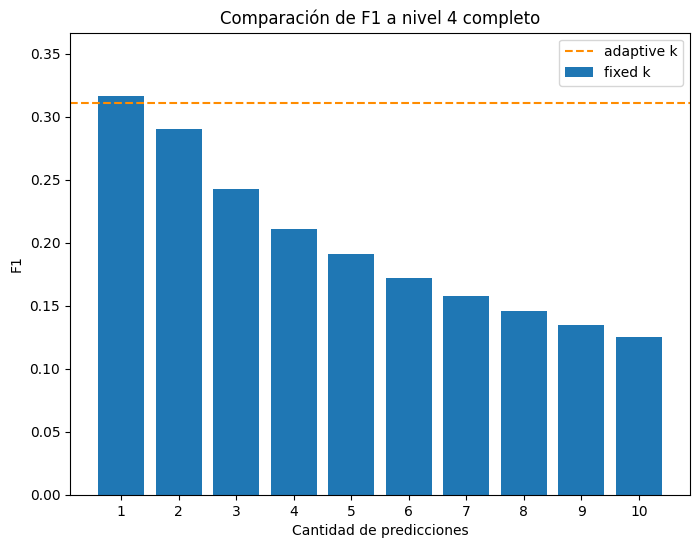

In [38]:
import matplotlib.pyplot as plt

f1_fixed = [average_f11,average_f12, average_f13, average_f14, average_f15, average_f16,average_f17,average_f18,average_f19, average_f110]  # Ejemplo para top-1, top-3, top-5, top-10
f1_adaptive = average_f1

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = range(len(labels))

plt.figure(figsize=(8, 6))
top_margin = max(max(f1_fixed), f1_adaptive) + 0.05
plt.ylim(0, min(1, top_margin))
plt.bar(x, f1_fixed, label='fixed k')
plt.axhline(f1_adaptive, color='darkorange', linestyle='--', label='adaptive k')

plt.xticks(x, labels)
plt.ylabel('F1')
plt.xlabel('Cantidad de predicciones')
plt.title('Comparación de F1 a nivel 4 completo')
plt.legend()
# plt.tight_layout()
plt.show()

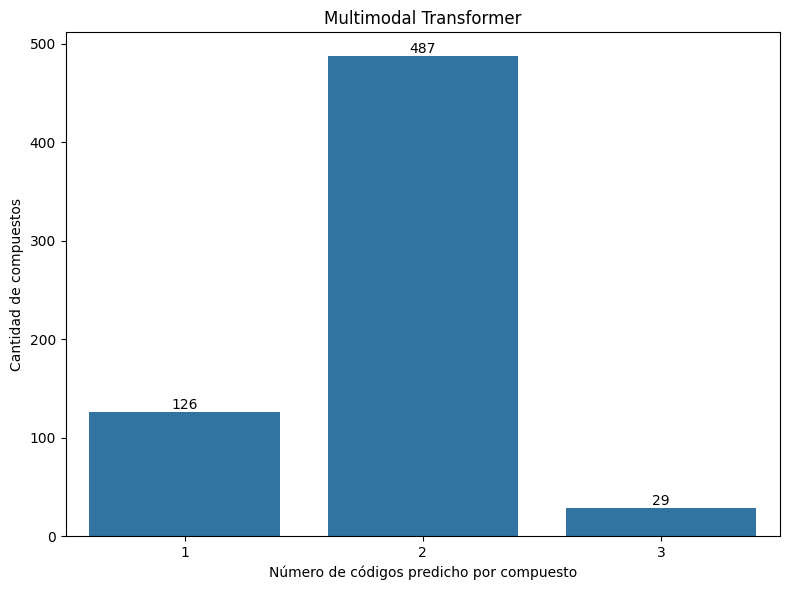

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_pred_int.flatten())
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Número de códigos predicho por compuesto')
plt.ylabel('Cantidad de compuestos')
plt.title('Multimodal Transformer')
plt.tight_layout()
plt.show()


A01AC; A07EA; C05AA; D07AA; D07BA; D07CA; D07XA; H02AB; R01AD; S01BA; S01BB; S01CA; S01CB; S02BA; S02CA; S03CA


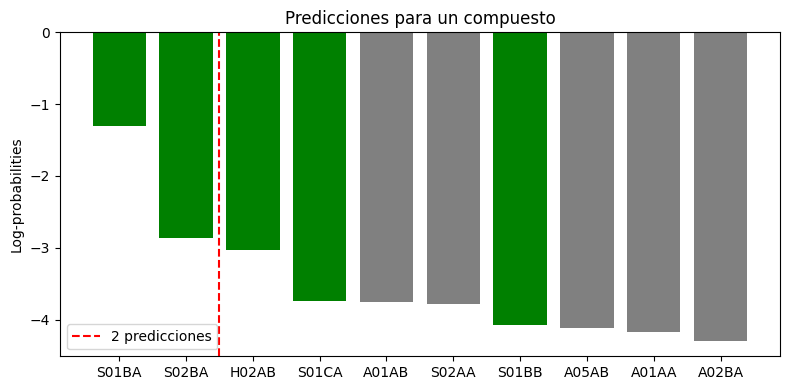

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
val = 79
clean_preds = []
for code in output_beam_test[val]:
    clean_preds.append(code[7:-5])
data = {
    'Código predicho': clean_preds,
    'Log-prob': log_probabilities_test.cpu()[val]
}
df = pd.DataFrame(data)
top_k = y_pred_int.flatten()[val]  # valor predicho por la red para este compuesto
reales = test_set['ATC Codes'][val]

# Gráfico
plt.figure(figsize=(8, 4))
bars = plt.bar(df['Código predicho'], df['Log-prob'], color=['green' if c in reales else 'gray' for c in df['Código predicho']])
print(reales)


plt.axvline(x=top_k - 0.5, color='red', linestyle='--', label=f'{top_k} predicciones')
plt.ylabel('Log-probabilities')
plt.title('Predicciones para un compuesto')
plt.legend()
plt.tight_layout()
plt.show()